# Case Description

You were hired as a data scientist in an important mutual fund firm (investment company) in the department of financial analysis. The firm has been doing financial analysis and financial forecast for several years. You were hired to come up with alternative approaches to do descriptive analytics in order to find better future alternatives for forecasting methods.

You have to analyze historical quarterly financial statements of all US public firms listed in the New York Exchange and NASDAQ. You will receive two datasetsin .csv format. The first dataset (dataus2023q2) contains the historical financial data of the firms, while the second dataset (firmsus2023) is a catalog of all firms along with the corresponding industry type and status (active or cancelled).

The dataus2023q2 dataset has a panel-data (also called long format) structure. Each row has financial information for one US firm and 1 period (a quarter). All $ amounts are in thousands (’1000s).

The main objectives of your analysis are a) To learn about the firm composition of whole US financial market (using all firms), and b) Select firms from 1 industry and then learn which financial factors/variables are related to stock return.

In the following sections you will find specific directions to calculate new variables/ratios, provide descriptive statistics and do a statistical analysis to aim the objective.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [78]:
from google.colab import drive

drive.mount("/content/gdrive")
!pwd
#put your own path in google drive
%cd "/content/gdrive/MyDrive/AI/Proyecto_Estadistica"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/AI/Proyecto_Estadistica
/content/gdrive/MyDrive/AI/Proyecto_Estadistica
dataus2023.csv	firmsus2023.csv


In [79]:
data = pd.read_csv("dataus2023.csv")
data.shape

firms = pd.read_csv("firmsus2023.csv")
firms.shape

(5615, 7)

In [80]:
data['qdate']=pd.PeriodIndex(data.q, freq="Q")

In [81]:
data.set_index(['firm', 'qdate'], inplace = True)

In [82]:
firms.columns
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]
firms1.columns = ['firm', 'Empresa', 'status', 'industria']

# Calculation of financial variables and ratios

* Calculate log quarterly returns (rq) and log annual returns (ry).

* Calculate 1-quarter future log quarterly returns (f1rq)

In [83]:
data['ry'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(4))
data['rq'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(1))

data['f1rq'] = data['rq'].shift(-1)
data['f4rq'] = data['rq'].shift(-4)

In [84]:
data = pd.merge(data, firms1, on="firm", how='left')
data[['firm', 'q', 'rq', 'ry', 'f1rq', 'f4rq']].head(10)

,firm,q,rq,ry,f1rq,f4rq
0,A,2000q1,NaN,NaN,-0.343710,-0.577538
1,A,2000q2,-0.343710,NaN,-0.410137,0.056001
2,A,2000q3,-0.410137,NaN,0.112233,-0.508265
3,A,2000q4,0.112233,NaN,-0.577538,0.377280
4,A,2001q1,-0.577538,-1.219152,0.056001,0.203950
5,A,2001q2,0.056001,-0.819441,-0.508265,-0.390841
6,A,2001q3,-0.508265,-0.917569,0.377280,-0.593809
7,A,2001q4,0.377280,-0.652522,0.203950,0.318593
8,A,2002q1,0.203950,0.128965,-0.390841,-0.311725
9,A,2002q2,-0.390841,-0.317877,-0.593809,0.396554


* Calculate operating profit (also called earnings before interest and taxes) : ebit = revenue - cogs - sgae

* Calculate operating profit margin: opm = ebit / revenue

* Calculate net income as: netincome = ebit + otherincome + extraordinaryitems - financial expenses - incometax

* Calculate profit margin (ratio) as: pm = ni / revenue

* Calculate asset turn over ratio: ato = revenue / totalassets

* Calculate acid ratio: acidratio = currentassets / currentliabilities

* Calculate financial leverage ratio as: finlev=longdebt / totalassets

* Calculate market value as: mvalue = originalprice * sharesoutstanding

* Calculate book value as: bookvalue = totalassets - totalliabilities

In [85]:
data['ebit']= data['revenue'] - data['cogs'] - data['sgae']
data['opm']= np.where(data['revenue']==0,np.NaN,data['ebit']/data['revenue'])
data['netincome']= data['ebit'] - data['extraordinaryitems'] - data['incometax'] -data ['finexp']
data['pm']= np.where(data['revenue']==0,np.NaN,data['netincome']/data['revenue'])
data['ato']= np.where(data['totalassets']==0,np.NaN,data['revenue']/data['totalassets'])
data['acidratio']= np.where(data['currentliabilities']==0,np.NaN,data['currentassets']/data['currentliabilities'])
data['finlev']= np.where(data['totalassets']==0,np.NaN,data['longdebt']/data['totalassets'])
data['mvalue']= data['originalprice'] * data['sharesoutstanding']
data['bookvalue']= data['totalassets'] - data['totalliabilities']

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533088 entries, 0 to 533087
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   firm                533088 non-null  object 
 1   q                   533088 non-null  object 
 2   fiscalmonth         240848 non-null  float64
 3   revenue             240837 non-null  float64
 4   cogs                240837 non-null  float64
 5   sgae                209734 non-null  float64
 6   otherincome         240837 non-null  float64
 7   extraordinaryitems  209734 non-null  float64
 8   finexp              240837 non-null  float64
 9   incometax           240837 non-null  float64
 10  totalassets         240842 non-null  float64
 11  currentassets       234044 non-null  float64
 12  inventory           198227 non-null  float64
 13  totalliabilities    240841 non-null  float64
 14  currentliabilities  198231 non-null  float64
 15  longdebt            222677 non-nul

# Firm Composition of the US financial market

In [86]:
data.status.unique()

array(['activo', 'cancelado'], dtype=object)

* Show how many active firms by industry there are in the sample

In [87]:
active_2023q2=data.loc[(data['status']=="activo")&(data['q']=="2023q2")]
active_2023q2[["industria", 'firm']].groupby('industria').count()

,firm
industria,
-,2
"Agricultura, ganadería, aprovechamiento forestal, pesca y caza",17
Comercio al por mayor,79
Comercio al por menor,145
Construcción,46
"Empresas de electricidad, gas y agua",77
Industrias manufactureras,1540
Información en medios masivos,256
"Minería, explotación de canteras y extracción de petróleo y gas",113


In [88]:
industrysummary = active_2023q2.groupby('industria').agg(
    {
    'firm':['count'],
    'mvalue': ['min', 'max', 'mean', 'median', 'std'],
    'bookvalue': ['min', 'max', 'mean', 'median', 'std']
    }
)
industrysummary

firm        mvalue  \
                                                   count           min   
industria                                                                
-                                                      2  5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...    17  3.687575e+03   
Comercio al por mayor                                 79  5.458413e+03   
Comercio al por menor                                145  3.795684e+03   
Construcción                                          46  2.212283e+03   
Empresas de electricidad, gas y agua                  77  3.372824e+04   
Industrias manufactureras                           1540  7.961721e+02   
Información en medios masivos                        256  3.256724e+03   
Minería, explotación de canteras y extracción d...   113  3.417000e+01   
Otros servicios excepto actividades gubernament...    17  1.674210e+04   
Servicios de alojamiento temporal y de preparac...    71  9.806644e+03   
Servicios de apoyo a los negocios y manejo de r...   128  2.802163e+03   
Servicios de esparcimiento culturales y deporti...    24  3.092327e+03   
Servicios de salud y de asistencia social             63  7.174165e+02   
Servicios educativos                                  13  8.398636e+04   
Servicios financieros y de seguros                   686  5.559044e+03   
Servicios inmobiliarios y de alquiler de bienes...    68  3.440615e+03   
Servicios profesionales, científicos y técnicos      137  3.638322e+03   
Transportes, correos y almacenamiento                 70  2.981646e+04   

                                                                  \
                                                             max   
industria                                                          
-                                                   5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...  4.505009e+07   
Comercio al por mayor                               5.764514e+07   
Comercio al por menor                               1.337540e+09   
Construcción                                        4.150495e+07   
Empresas de electricidad, gas y agua                1.501596e+08   
Industrias manufactureras                           3.050896e+09   
Información en medios masivos                       2.532081e+09   
Minería, explotación de canteras y extracción d...  6.980866e+07   
Otros servicios excepto actividades gubernament...  9.764061e+06   
Servicios de alojamiento temporal y de preparac...  2.174703e+08   
Servicios de apoyo a los negocios y manejo de r...  4.448753e+08   
Servicios de esparcimiento culturales y deporti...  1.631418e+08   
Servicios de salud y de asistencia social           8.351460e+07   
Servicios educativos                                3.171234e+06   
Servicios financieros y de seguros                  7.507354e+08   
Servicios inmobiliarios y de alquiler de bienes...  1.952017e+08   
Servicios profesionales, científicos y técnicos     1.519831e+09   
Transportes, correos y almacenamiento               1.539554e+08   

                                                                  \
                                                            mean   
industria                                                          
-                                                   5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...  7.682534e+06   
Comercio al por mayor                               6.028485e+06   
Comercio al por menor                               2.472093e+07   
Construcción                                        5.996741e+06   
Empresas de electricidad, gas y agua                1.544664e+07   
Industrias manufactureras                           1.290139e+07   
Información en medios masivos                       2.339430e+07   
Minería, explotación de canteras y extracción d...  6.854571e+06   
Otros servicios excepto actividades gubernament...  1.956204e+06   
Servicios de alojamiento temporal y de pre

* For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed? You have to do the right descriptive statistics

IN ORDER TO DESCRIBE THE TYPICAL FIRM SIZE IN ACCORDANCE TO THE MARKET VALUE AND THE BOOK VALUE, I WILL BE ANALYZING THE MEDIAN VALUES ACCORDINGLY, DUE THE FACT THAT THE MEAN, IN THIS CASE, DOES NOT REPRESENT THE TRUE 50TH PERCENTILE OF THE INDUSTRIES.

NOW TAKING THE AVERAGE OF THE MEDIANS FOR ALL THE INDUSTRIES WE FIND OUT THAT FOR ANY TYPE OF INDUSTRY THE MEDIAN FOR THE MARKET VALUE IS: , AND THE BOOK VALUE IS:

NOW THE MARKET VALUE AND THE BOOK VALUE DIFFER FROM WITHIN INDUSTRIES WITH THE FOLLOWING VALUES:



In [89]:
# Selecciono mi industria:

dataser= data.loc[(data['industria']== 'Servicios de alojamiento temporal y de preparación de alimentos y bebidas') | (data['industria']=='Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación') | (data['industria']=="Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos") | (data['industria']=="Servicios de salud y de asistencia social") | (data['industria']=="Servicios educativos") | (data['industria']=="Servicios profesionales, científicos y técnicos") | (data['industria']=="Servicios inmobiliarios y de alquiler de bienes muebles e intangibles") | (data['industria']=="Transportes, correos y almacenamiento")]
dataser[['industria']].head()

,industria
190,"Servicios profesionales, científicos y técnicos"
191,"Servicios profesionales, científicos y técnicos"
192,"Servicios profesionales, científicos y técnicos"
193,"Servicios profesionales, científicos y técnicos"
194,"Servicios profesionales, científicos y técnicos"


In [90]:
dataser2022 = dataser.loc[(dataser['year']==2022) & (dataser['fiscalmonth']==12) & (dataser['status']=='activo')]
dataser2022 = dataser2022[['firm','q','revenue','netincome','mvalue','bookvalue','opm','pm','ato','finlev','acidratio','rq','f1rq']]
dataser2022.describe()

,revenue,netincome,mvalue,bookvalue,opm,pm,ato,finlev,acidratio,rq,f1rq
count,5.550000e+02,5.500000e+02,5.500000e+02,5.550000e+02,545.000000,545.000000,555.000000,533.000000,527.000000,548.000000,550.000000
mean,4.833988e+06,3.555505e+05,1.112014e+07,2.538049e+06,-2.118152,-2.765817,0.884458,0.332503,3.013270,-0.016142,0.033040
std,1.604355e+07,3.291170e+06,5.714457e+07,1.337700e+07,23.474751,34.774712,1.489658,0.291073,10.310960,0.289725,0.266429
min,0.000000e+00,-1.675900e+07,3.455370e+03,-8.876000e+06,-459.916667,-755.416667,0.000000,0.000000,0.061452,-1.845058,-1.374598
25%,2.762975e+05,-2.898000e+04,3.219927e+05,7.116205e+04,-0.061337,-0.089161,0.364548,0.090553,1.000816,-0.121734,-0.082171
50%,9.679960e+05,1.827400e+04,1.444956e+06,4.802230e+05,0.060719,0.030860,0.627985,0.289875,1.465848,0.041209,0.042836
75%,3.663277e+06,2.125865e+05,5.335943e+06,1.665617e+06,0.152147,0.093356,1.071085,0.487532,2.378899,0.154247,0.166593
max,2.828360e+08,6.348600e+07,1.141961e+09,2.561440e+08,0.810083,0.686365,29.462489,1.959117,208.291382,0.883855,1.205105


In [91]:
#Dataset con toda la historia, pero que sea información anual

datasery = dataser[dataser['fiscalmonth']==12]
datasery[['fiscalmonth','revenue']].head()

,fiscalmonth,revenue
193,12.0,1110178.0
197,12.0,717422.0
201,12.0,953067.0
205,12.0,1625097.0
209,12.0,3574517.0


In [92]:
# Calculo logaritmo de las variables financieras (no de los ratios)

dataser['logta'] = np.where(dataser['totalassets']==0,np.NaN,np.log(dataser['totalassets']))
dataser['logrev'] = np.where(dataser['revenue']==0,np.NaN,np.log(dataser['revenue']))
dataser['logni'] = np.where(dataser['netincome']==0,np.NaN,np.log(dataser['netincome']))

dataser.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

<ipython-input-92-a8018b40a68f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log

<ipython-input-92-a8018b40a68f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,netincome,pm,ato,acidratio,finlev,mvalue,bookvalue,logta,logrev,logni
190,AABA_old,2000q1,3.0,228384.0,34467.0,119051.0,0.0,54886.0,0.0,51901.0,...,-31921.0,-0.139769,0.120644,4.567879,0.0,9.195820e+07,1646664.0,14.453691,12.338784,NaN
191,AABA_old,2000q2,6.0,498500.0,73796.0,256947.0,0.0,71093.0,0.0,95540.0,...,1124.0,0.002255,0.244604,4.220439,0.0,6.804912e+07,1756999.0,14.527473,13.119359,7.024649
192,AABA_old,2000q3,9.0,799305.0,116105.0,472842.0,0.0,99379.0,0.0,141142.0,...,-30163.0,-0.037737,0.346045,3.783349,0.0,5.081647e+07,1943466.0,14.652684,13.591498,NaN
193,AABA_old,2000q4,12.0,1110178.0,158419.0,653939.0,-33701.0,-5298.0,0.0,188045.0,...,115073.0,0.103653,0.489157,4.147583,0.0,1.678758e+07,1926227.0,14.635104,13.920031,11.653322
194,AABA_old,2001q1,3.0,180215.0,40636.0,172347.0,23276.0,229.0,0.0,2223.0,...,-35220.0,-0.195433,0.074790,3.438097,0.0,8.928754e+06,2044310.0,14.694982,12.101906,NaN


In [93]:
t_firm = active_2023q2.groupby('industria')['bookvalue'].mean().to_frame()
t_firm = t_firm.rename(columns={'bookvalue': 'book mean'})
t_firm['book median'] = active_2023q2.groupby('industria')['bookvalue'].median()

t_firm['market mean'] = active_2023q2.groupby('industria')['mvalue'].mean()
t_firm['market median'] = active_2023q2.groupby('industria')['mvalue'].median()

t_firm

,book mean,book median,market mean,market median
industria,,,,
-,5.948964e+06,5.948964e+06,5.231092e+06,5.231092e+06
"Agricultura, ganadería, aprovechamiento forestal, pesca y caza",1.326740e+06,7.245920e+05,7.682534e+06,8.579215e+05
Comercio al por mayor,1.689150e+06,8.833000e+05,6.028485e+06,1.450954e+06
Comercio al por menor,3.691997e+06,5.443400e+05,2.472093e+07,1.662159e+06
Construcción,2.934480e+06,1.190225e+06,5.996741e+06,2.559769e+06
"Empresas de electricidad, gas y agua",8.103911e+06,3.332000e+06,1.544664e+07,5.192341e+06
Industrias manufactureras,2.624806e+06,2.776380e+05,1.290139e+07,6.843268e+05
Información en medios masivos,4.331265e+06,5.079650e+05,2.339430e+07,2.370195e+06
"Minería, explotación de canteras y extracción de petróleo y gas",3.522103e+06,9.985605e+05,6.854571e+06,1.118079e+06


In [94]:
fig = px.box(active_2023q2, x='industria', y='mvalue')

fig.update_xaxes(
    title_text='Industria',  # Set the x-axis title
    tickfont=dict(size=10)  # Set the font size for x-axis labels
)

fig.show()

In [95]:
fig2 = px.box(active_2023q2, x='industria', y='bookvalue')

fig2.update_xaxes(
    title_text='Industria',  # Set the x-axis title
    tickfont=dict(size=10)  # Set the font size for x-axis labels
)

fig2.show()

* Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?

In [96]:
active_2023q2[['firm','mvalue', 'Empresa', 'industria']].sort_values(by='mvalue', ascending=False).head(10)

,firm,mvalue,Empresa,industria
1138,AAPL,3.050896e+09,Apple Inc,Industrias manufactureras
316182,MSFT,2.532081e+09,Microsoft Corp,Información en medios masivos
207232,GOOGL,1.519831e+09,Alphabet Inc,"Servicios profesionales, científicos y técnicos"
28396,AMZN,1.337540e+09,"Amazon.Com, Inc",Comercio al por menor
338687,NVDA,1.044859e+09,Nvidia Corp,Industrias manufactureras
478367,TSLA,8.296811e+08,"Tesla, Inc",Industrias manufactureras
72866,BRK_A,7.507354e+08,Berkshire Hathaway Inc,Servicios financieros y de seguros
301173,META,7.354528e+08,"Meta Platforms, Inc","Servicios profesionales, científicos y técnicos"
489577,UNH,4.474912e+08,Unitedhealth Group Inc,Servicios financieros y de seguros
280653,LLY,4.451900e+08,Eli Lilly And Company,Industrias manufactureras


In [97]:
print(active_2023q2['mvalue'].median())

1170074.0124050002


In [98]:
fig = px.histogram(active_2023q2['mvalue'], nbins=30)

fig.update_xaxes(title_text='Values in Millions', tickformat='.2s')
fig.update_yaxes(title_text='Frequency')
fig.show()

* Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?

In [99]:
active_2023q2[['firm','bookvalue', 'Empresa', 'industria']].sort_values(by='bookvalue', ascending=False).head(10)

,firm,bookvalue,Empresa,industria
72866,BRK_A,539883000.0,Berkshire Hathaway Inc,Servicios financieros y de seguros
259753,JPM,312516000.0,Jpmorgan Chase & Co,Servicios financieros y de seguros
53286,BAC,283319000.0,Bank Of America Corp,Servicios financieros y de seguros
207232,GOOGL,267141000.0,Alphabet Inc,"Servicios profesionales, científicos y técnicos"
79421,C,209422000.0,Citigroup Inc,Servicios financieros y de seguros
525961,XOM,206997000.0,Exxon Mobil Corp,Industrias manufactureras
316182,MSFT,206223000.0,Microsoft Corp,Información en medios masivos
513136,WFC,181952000.0,Wells Fargo & Company,Servicios financieros y de seguros
28396,AMZN,168602000.0,"Amazon.Com, Inc",Comercio al por menor
127623,CVX,159298000.0,Chevron Corp,Industrias manufactureras


In [100]:
print(active_2023q2['bookvalue'].median())

500654.5


In [101]:
import plotly.express as px
fig = px.histogram(active_2023q2['bookvalue'], nbins=30)

fig.update_xaxes(title_text='Values in Millions', tickformat='.2s')
fig.update_yaxes(title_text='Frequency')
fig.show()

# Evolution of the US financial market

Considering the whole history of financial data for all firms, and only annual fiscal information (selecting fiscalmonth=12) :

* How the total market value of the US market has changed over the years? Do a table and/or graph and explain

* How total revenue and total net income of all US firms has changed over the years? Do a table and/or graph and explain

In [102]:
datay = data.loc[(data['fiscalmonth'] == 12) & (data['year'] < 2023)]
fmarket = datay[['year', 'mvalue', 'revenue', 'netincome']].groupby('year').sum()
fmarket

,mvalue,revenue,netincome
year,,,
2000,1.281498e+10,6.380673e+09,2.697602e+08
2001,1.149439e+10,7.493007e+09,1.241661e+08
2002,9.494723e+09,7.320441e+09,3.352811e+08
2003,1.167595e+10,7.924777e+09,3.194297e+08
2004,1.323088e+10,8.816237e+09,4.268007e+08
2005,1.378911e+10,9.645439e+09,4.789271e+08
2006,1.546125e+10,1.054036e+10,5.226893e+08
2007,1.614913e+10,1.125665e+10,5.098830e+08
2008,1.039502e+10,1.160798e+10,3.273042e+08


In [103]:
fmarket = fmarket.loc[fmarket.index]

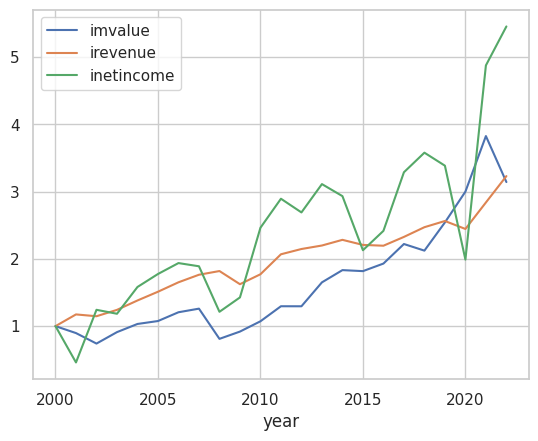

In [104]:
fmarket['imvalue'] = fmarket['mvalue'] / fmarket['mvalue'][2000]
fmarket['irevenue'] = fmarket['revenue'] / fmarket['revenue'][2000]
fmarket['inetincome'] = fmarket['netincome'] / fmarket['netincome'][2000]

fmarket.plot(y=['imvalue', 'irevenue', 'inetincome'])
plt.show()

# Learing about one industry

La industria con la cuál estaré trabajando para esta sección será las industrias manufactureras.

In [105]:
#selecciono industria
dataser= data.loc[(data['industria']== 'Servicios de alojamiento temporal y de preparación de alimentos y bebidas') | (data['industria']=='Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación') | (data['industria']=="Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos") | (data['industria']=="Servicios de salud y de asistencia social") | (data['industria']=="Servicios educativos") | (data['industria']=="Servicios profesionales, científicos y técnicos") | (data['industria']=="Servicios inmobiliarios y de alquiler de bienes muebles e intangibles") | (data['industria']=="Transportes, correos y almacenamiento")]
dataser[['industria']].head()

,industria
190,"Servicios profesionales, científicos y técnicos"
191,"Servicios profesionales, científicos y técnicos"
192,"Servicios profesionales, científicos y técnicos"
193,"Servicios profesionales, científicos y técnicos"
194,"Servicios profesionales, científicos y técnicos"


# Descriptive statistics for your industry

Using the subsample of your industry and using annual fiscal information (selecting rows with fiscalmonth=12), and the most recent complete year (2022), do the following:

* Show descriptive statistics for future quarterly log return, annual return, total assets, revenue, netincome and all financial ratios calculated above. Provide a clear interpretation of the descriptive statistics of revenue and 1 financial ratio

In [106]:
#selecciono las columnas de las variables a analizar
#'firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue'
dataset2022 = dataser.loc[(dataser['year']==2022)&(dataser['fiscalmonth']==12) & (dataser['status']=="activo")]
dataset2022 = dataset2022[['firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue']]
dataset2022.describe()

,f1rq,ry,rq,totalassets,revenue,netincome,opm,pm,ato,finlev,acidratio,mvalue,bookvalue
count,550.000000,540.000000,548.000000,5.550000e+02,5.550000e+02,5.500000e+02,545.000000,545.000000,555.000000,533.000000,527.000000,5.500000e+02,5.550000e+02
mean,0.033040,-0.452699,-0.016142,7.697660e+06,4.833988e+06,3.555505e+05,-2.118152,-2.765817,0.884458,0.332503,3.013270,1.112014e+07,2.538049e+06
std,0.266429,0.621442,0.289725,2.296538e+07,1.604355e+07,3.291170e+06,23.474751,34.774712,1.489658,0.291073,10.310960,5.714457e+07,1.337700e+07
min,-1.374598,-3.314782,-1.845058,2.704282e+03,0.000000e+00,-1.675900e+07,-459.916667,-755.416667,0.000000,0.000000,0.061452,3.455370e+03,-8.876000e+06
25%,-0.082171,-0.685847,-0.121734,4.785685e+05,2.762975e+05,-2.898000e+04,-0.061337,-0.089161,0.364548,0.090553,1.000816,3.219927e+05,7.116205e+04
50%,0.042836,-0.303200,0.041209,1.733400e+06,9.679960e+05,1.827400e+04,0.060719,0.030860,0.627985,0.289875,1.465848,1.444956e+06,4.802230e+05
75%,0.166593,-0.045514,0.154247,5.945813e+06,3.663277e+06,2.125865e+05,0.152147,0.093356,1.071085,0.487532,2.378899,5.335943e+06,1.665617e+06
max,1.205105,1.235678,0.883855,3.652640e+08,2.828360e+08,6.348600e+07,0.810083,0.686365,29.462489,1.959117,208.291382,1.141961e+09,2.561440e+08


Using annual fiscal data (selecting rows with fiscalmonth=12), and all years:

In [114]:
datasety= dataser.loc[(dataser['fiscalmonth']==12) & (dataser['status']=="activo")]
datasety = datasety[['firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue']]
datasety.describe()

,f1rq,ry,rq,totalassets,revenue,netincome,opm,pm,ato,finlev,acidratio,mvalue,bookvalue
count,6213.000000,5684.000000,6134.000000,6.516000e+03,6.515000e+03,6.481000e+03,6438.000000,6438.000000,6515.000000,6267.000000,6234.000000,6.158000e+03,6.516000e+03
mean,0.003135,0.026157,0.023147,6.311967e+06,4.023808e+06,2.962504e+05,-1.174258,-1.211593,0.947526,0.272559,2.353425,1.047869e+07,2.213705e+06
std,0.273399,0.506159,0.251749,1.603412e+07,1.018310e+07,1.894726e+06,28.036721,26.494866,1.004083,0.291646,5.311153,5.719124e+07,9.315745e+06
min,-2.280112,-4.915325,-2.202502,7.380000e-01,0.000000e+00,-1.675900e+07,-1404.971429,-1226.314286,0.000000,0.000000,0.002831,1.125142e+03,-2.556000e+07
25%,-0.091097,-0.173667,-0.081685,3.840415e+05,2.703370e+05,-5.321000e+03,0.009073,-0.021266,0.421911,0.043958,0.987058,4.504288e+05,9.703625e+04
50%,0.029913,0.083238,0.043669,1.560290e+06,1.082158e+06,3.947600e+04,0.077157,0.041470,0.717154,0.226712,1.426676,1.702196e+06,4.879025e+05
75%,0.138925,0.298886,0.159373,5.301045e+06,3.616307e+06,2.070000e+05,0.161017,0.097481,1.239240,0.410432,2.224119,5.618335e+06,1.606816e+06
max,2.023202,2.930813,1.625311,3.652640e+08,2.828360e+08,6.401300e+07,7.170382,46.390129,32.355468,7.477906,208.291382,2.256959e+09,2.561440e+08


* Show a correlation matrix with the same variables you used for descriptive statistics above, but in the case of totalassets, revenue and netincome, use the logarithmic transformation of their values. Which variables have strongest and significant linear relationship with stock returns (annual and quarterly)? Explain

In [115]:
#calculo el logaritmo de las variables financieras (no de los ratios)

datasety['logta'] = np.where(datasety['totalassets']==0, np.NaN,np.log(datasety['totalassets']))
datasety['logrev'] = np.where(datasety['revenue']==0, np.NaN,np.log(datasety['revenue']))
datasety['logni'] = np.where(datasety['netincome']==0, np.NaN,np.log(datasety['netincome']))
datasety[['firm', 'logta', 'logrev', 'logni']].head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



,firm,logta,logrev,logni
478,AAL,17.081766,16.796281,13.425427
482,AAL,17.307188,16.758000,NaN
486,AAL,17.225569,16.666159,NaN
490,AAL,17.194121,16.674277,NaN
494,AAL,17.174948,16.741089,NaN


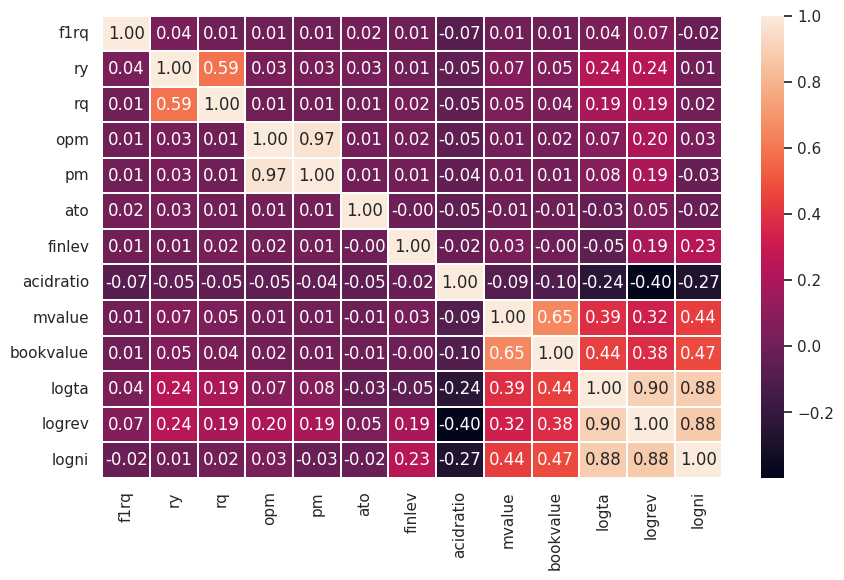

In [109]:
#calculo la matriz de correlación
corr_matrix = datasety[['f1rq', 'ry', 'rq', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue', 'logta', 'logrev', 'logni']].corr()
plt.figure(figsize=(10,6))
sn.heatmap(corr_matrix, annot = True,linewidths=0.3,fmt='0.2f')
plt.show()

Select 2-3 variables and 2-3 ratios with the strongest correlation with future log quarterly returns and do the following:

Las variables con las correlaciones más fuertes con "f1rq" (future log quarterly returns) fueron:

* logta (logarithmic transformation of total assets)
* logrev (logarithmic transformation of revenue)
* acidratio

* Do histograms for each factor/variables and interpret them

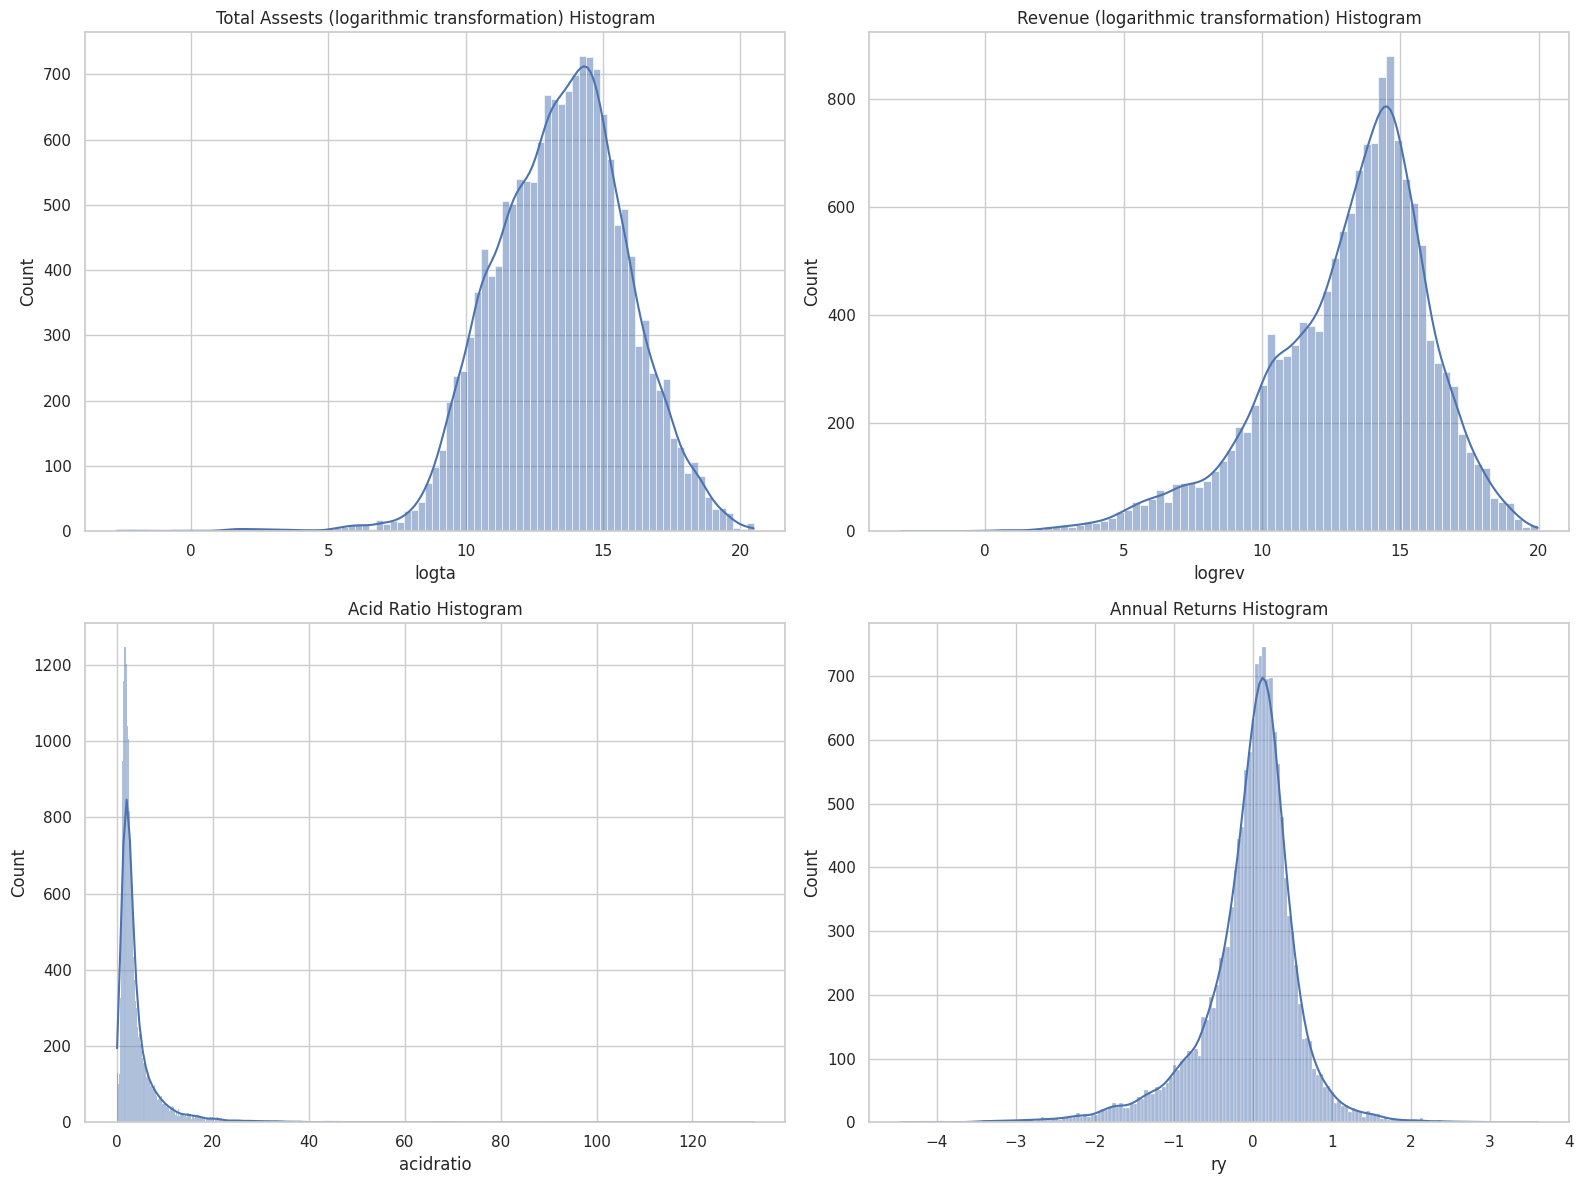

In [110]:
sn.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

sn.histplot(data=datasety, x="logta", kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Total Assests (logarithmic transformation) Histogram")

sn.histplot(data=datasety, x="logrev", kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Revenue (logarithmic transformation) Histogram")

sn.histplot(data=datasety, x="acidratio", kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Acid Ratio Histogram")

sn.histplot(data=datasety, x="ry", kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Annual Returns Histogram")

plt.tight_layout()

plt.show()

* Do plots to visualize the possible relationship each factor might have with quarterly returns (the dependent variable).

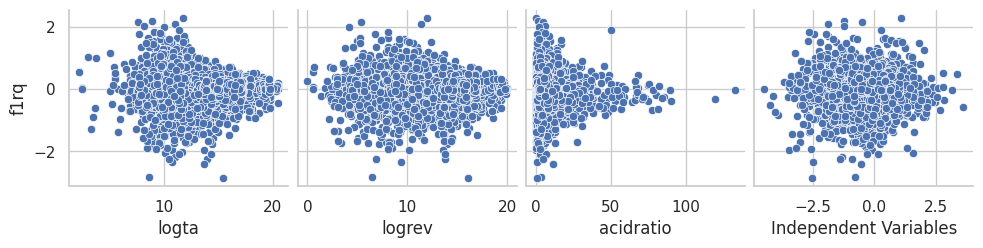

In [111]:
sn.pairplot(data=datasety, y_vars=['f1rq'], x_vars=['logta', 'logrev', 'acidratio', 'ry'])

plt.xlabel('Independent Variables')
plt.ylabel('Quarterly Returns (rq)')

plt.show()

* Design and run a first version of a multiple regression model to examine whether your selected factors can explain/predict quarterly stock returns.



In [112]:
#datasetnad = datasety.dropna()

X = datasety[['logta', 'logrev', 'acidratio', 'ry']]
X = sm.add_constant(X)

Y = datasety[['f1rq']]
mkmodel = sm.OLS(Y, X,missing= "drop").fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1rq   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     28.19
Date:                Thu, 07 Sep 2023   Prob (F-statistic):           2.34e-23
Time:                        14:35:51   Log-Likelihood:                -2298.4
No. Observations:               13710   AIC:                             4607.
Df Residuals:                   13705   BIC:                             4645.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0224      0.017     -1.302      0.1

* You must check for possible multicollinearity problems. Briefly explain what is multicollinearity, run and interpret the corresponding test



* (OPTIONAL) For each independent variable (variable/ratio) check if winsorization is needed according to very extreme values. You can check this with the histograms of each variable/ratio. If it is necessary do the corresponding adjustments with winsorization to avoid unreliable results in your regression model

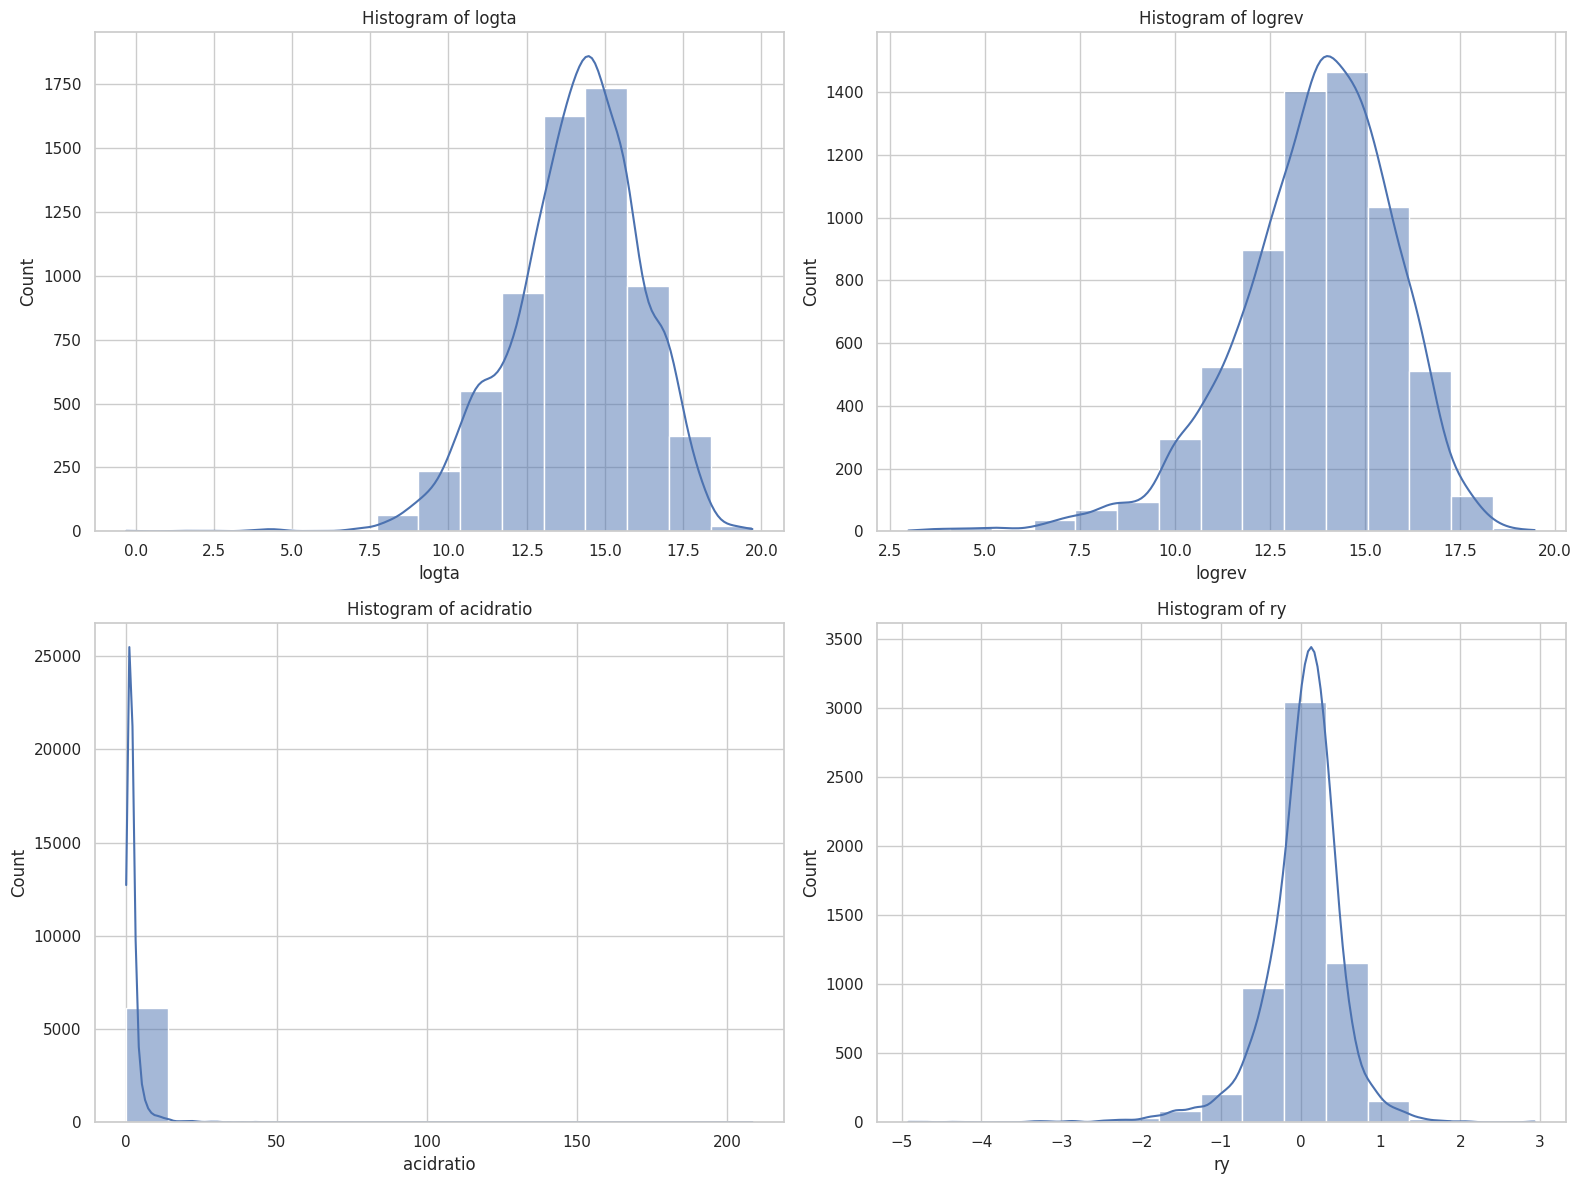

In [116]:
variables = ['logta', 'logrev', 'acidratio', 'ry']
plt.figure(figsize=(16, 12))
selected_variables = variables[:4]

for i, var in enumerate(selected_variables, 1):
    plt.subplot(2, 2, i)
    sn.histplot(datasety[var], bins=15, kde=True)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)

plt.tight_layout()
plt.show()

* Once you corrected your variables/ratios with winsorization (in case you did it) and addressed possible multicollienarity problems, run a final multiple regression model

# Interpret your model

In [117]:
#datasetnad = datasety.dropna()

X = datasety[['logta', 'logrev', 'acidratio']]
X = sm.add_constant(X)

Y = datasety[['f1rq']]
mkmodel = sm.OLS(Y, X, missing= "drop").fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1rq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.518
Date:                Thu, 07 Sep 2023   Prob (F-statistic):           0.000882
Time:                        14:37:58   Log-Likelihood:                -739.31
No. Observations:                5928   AIC:                             1487.
Df Residuals:                    5924   BIC:                             1513.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.027      0.654      0.5

* Interpret with your own words the results of each coefficient (beta and their statistical significance)

* Interpret the R-squared of the model

* Write a conclusion of your results